# Data Exploration

---

### Importing required libraries

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import re
import json

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 180)

## Loading data

Next we set the path to our csv datafile and read it using Pandas

In [23]:
CSV_PATH = '../transactions.csv'  # Path to the CSV file. Adjust as necessary.

df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

df.head(10)

,id,account_id,description,description_raw,category,currency_code,amount,balance,date,status,type,provider_code,created_at,updated_at,payment_data,credit_card_data,merchant
0,2ed4ba6a-8217-4794-8910-495ef2c9443e,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,150.00,NaN,2025-04-07 23:07:57.352,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN
1,cfcaafa7-244e-4127-88ad-f159012d8e73,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,180.00,NaN,2025-04-07 23:08:11.161,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN
2,bbc667d4-89e5-4b74-bb29-47f4528bd008,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,200.00,NaN,2025-04-07 23:08:23.939,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN
3,a7831333-4cea-4ca4-84a9-334d9c9d3885,bccb05e6-5f09-4aee-b8e4-719d85c09692,COMBO SANTANDER+,COMBO SANTANDER+,Supermercado,BRL,-69.90,NaN,2025-04-08 00:46:24.292,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN
4,3b9260e1-49b0-47c0-b243-fa590f209671,bccb05e6-5f09-4aee-b8e4-719d85c09692,MENSALIDADE DE SEGURO PROP.003675830730,MENSALIDADE DE SEGURO PROP.003675830730,Seguros,BRL,-31.99,NaN,2025-04-08 12:05:40.766,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN
5,e99dd6d1-6cb9-40a7-ae88-4df8db82d885,bccb05e6-5f09-4aee-b8e4-719d85c09692,DEBITO VISA ELECTRON BRASIL 09/04 PAO DE ACU...,DEBITO VISA ELECTRON BRASIL 09/04 PAO DE ACU...,Supermercado,BRL,-246.90,NaN,2025-04-10 00:09:42.667,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,"{""cnae"":""6422100"",""cnpj"":""90400888000142"",""nam..."
6,944a99ec-96a5-451f-baa5-72940c7ea5a0,bccb05e6-5f09-4aee-b8e4-719d85c09692,DEBITO VISA ELECTRON BRASIL 10/04 DROGASIL2459,DEBITO VISA ELECTRON BRASIL 10/04 DROGASIL2459,Farmácia,BRL,-119.99,NaN,2025-04-10 11:34:17.198,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,"{""cnae"":""6422100"",""cnpj"":""90400888000142"",""nam..."
7,a929c16a-06f6-4f34-81ca-049fbb753b9f,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO ESCUDERO CORPORATION,PIX RECEBIDO ESCUDERO CORPORATION,Transferência - PIX,BRL,1000.00,NaN,2025-04-10 13:03:24.539,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":""ESCUDERO CORPORATION"",""branc...",NaN,NaN
8,062d47d2-c218-4a3f-ad65-20415c02495e,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX ENVIADO SEM PARAR INSTITUICAO DE,PIX ENVIADO SEM PARAR INSTITUICAO DE,Pedágios e pagamentos no veículo,BRL,-922.35,NaN,2025-04-10 13:03:56.145,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,"{""cnae"":""8299799"",""cnpj"":""04088208000165"",""nam..."
9,264177aa-5d24-4da0-823d-c186d3de07d3,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX ENVIADO Paola Gomes,PIX ENVIADO Paola Gomes,Transferência - PIX,BRL,-80.00,NaN,2025-04-10 20:10:58.834,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN


---

## Setting some features

Note that we have some missing values in a few columns such as `balance`, `provider_code`, `credic_card_data` and `merchant`. For the sake of this Case and will only fill the balance column, since the others will not be used by our metrics and analysis.
This information, however, can be crucial for other applications, and therefore its use should analysed depending on the business requirements.

Lets see what we can do about balance. But first, we will define a few new columns

In [24]:
df['inflow']  = df['amount'].where(df['amount'] > 0, 0.0)
df['outflow'] = (-df['amount']).where(df['amount'] < 0, 0.0)
df['year_month'] = df['date'].dt.to_period('M')

df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6])
df['week_of_month'] = df['date'].dt.day.apply(lambda d: (d - 1)//7 + 1)

df.head()

,id,account_id,description,description_raw,category,currency_code,amount,balance,date,status,type,provider_code,created_at,updated_at,payment_data,credit_card_data,merchant,inflow,outflow,year_month,weekday,is_weekend,week_of_month
0,2ed4ba6a-8217-4794-8910-495ef2c9443e,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,150.00,NaN,2025-04-07 23:07:57.352,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,150.0,0.00,2025-04,0,False,1
1,cfcaafa7-244e-4127-88ad-f159012d8e73,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,180.00,NaN,2025-04-07 23:08:11.161,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,180.0,0.00,2025-04,0,False,1
2,bbc667d4-89e5-4b74-bb29-47f4528bd008,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,200.00,NaN,2025-04-07 23:08:23.939,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,200.0,0.00,2025-04,0,False,1
3,a7831333-4cea-4ca4-84a9-334d9c9d3885,bccb05e6-5f09-4aee-b8e4-719d85c09692,COMBO SANTANDER+,COMBO SANTANDER+,Supermercado,BRL,-69.90,NaN,2025-04-08 00:46:24.292,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN,0.0,69.90,2025-04,1,False,2
4,3b9260e1-49b0-47c0-b243-fa590f209671,bccb05e6-5f09-4aee-b8e4-719d85c09692,MENSALIDADE DE SEGURO PROP.003675830730,MENSALIDADE DE SEGURO PROP.003675830730,Seguros,BRL,-31.99,NaN,2025-04-08 12:05:40.766,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN,0.0,31.99,2025-04,1,False,2


We defined the inflow and outflow columns depending on the type of transaction (if amount is positive or negative). We also created a year-month column in order to use it later and easily have access to monthly agregated data.

The `weekday`, `is_weekend` and `week_of_month` columns will not be used in our metrics, but they are example of features that could be incorporated in a different type of analysis. For example, with a larger dataset, it would be possible to construct a model to predict fraud, and having the day of the week as an input to a fraud detection model could yield better results. 
The week_of_month feature will not be used as well. But again, with a larger dataset, this feature could be used to give weekly reports to the client, based on historical data and trends observed in his past behaviour.

We can see in the next cell that this dataset represents transactions of a single client (single account_id)

In [25]:
df['account_id'].nunique()

1

Now we can fill the balance column. This will be done cumulatively in cronological order throughout our dataset. The values for the balance are stored in a new column names balance_reconstructed

In [26]:
if 'account_id' in df.columns:
    df = df.sort_values(['account_id', 'date']).reset_index(drop=True)
    df['balance_reconstructed'] = df.groupby('account_id')['amount'].cumsum()
else:
    df = df.sort_values(['date']).reset_index(drop=True)
    df['balance_reconstructed'] = df['amount'].cumsum()

In [27]:
df.head()

,id,account_id,description,description_raw,category,currency_code,amount,balance,date,status,type,provider_code,created_at,updated_at,payment_data,credit_card_data,merchant,inflow,outflow,year_month,weekday,is_weekend,week_of_month,balance_reconstructed
0,2ed4ba6a-8217-4794-8910-495ef2c9443e,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,150.00,NaN,2025-04-07 23:07:57.352,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,150.0,0.00,2025-04,0,False,1,150.00
1,cfcaafa7-244e-4127-88ad-f159012d8e73,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,180.00,NaN,2025-04-07 23:08:11.161,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,180.0,0.00,2025-04,0,False,1,330.00
2,bbc667d4-89e5-4b74-bb29-47f4528bd008,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,200.00,NaN,2025-04-07 23:08:23.939,POSTED,CREDIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":""3263"",""a...",NaN,NaN,200.0,0.00,2025-04,0,False,1,530.00
3,a7831333-4cea-4ca4-84a9-334d9c9d3885,bccb05e6-5f09-4aee-b8e4-719d85c09692,COMBO SANTANDER+,COMBO SANTANDER+,Supermercado,BRL,-69.90,NaN,2025-04-08 00:46:24.292,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN,0.0,69.90,2025-04,1,False,2,460.10
4,3b9260e1-49b0-47c0-b243-fa590f209671,bccb05e6-5f09-4aee-b8e4-719d85c09692,MENSALIDADE DE SEGURO PROP.003675830730,MENSALIDADE DE SEGURO PROP.003675830730,Seguros,BRL,-31.99,NaN,2025-04-08 12:05:40.766,POSTED,DEBIT,NaN,2025-07-29 13:47:58.767,2025-07-30 04:30:22.894,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN,0.0,31.99,2025-04,1,False,2,428.11


---

## Metric features

Here we define a few metrics and apply them to our data. Lets see how these metrics are computed.

The most important thing to keep in mind is that, since we wish to construct metrics to send messages/alerts/suggestions to a client, these metrics should not be blind to past data. That is, they should take into account the trend of the clients transactions, payments, reibursements etc.

### Overview
This step processes transactions **chronologically**, maintaining **per-category running statistics** so that each row is evaluated against the **historical behavior** of its category.  
We combine both **classical (mean/std)** and **robust (median/MAD/IQR)** statistics with an **adaptive z-threshold** that depends on historical variability.

---

### Running Moments per Category
For each category `c`, we maintain:

- `cat_counts[c] = n`: number of previous positive outflows.  
- `cat_mean[c] = μ`: running mean (updated via Welford’s algorithm).  
- `cat_M2[c] = M2`: running sum of squared deviations used to compute variance.  
- `cat_values[c]`: full history of outflows (for robust stats).

From these:

- **Mean:** `mean_prev = μ`  
- **Standard deviation:** `std_prev = sqrt(M2 / (n − 1))` (if `n ≥ 2`)  
- **Coefficient of variation:** `cv_prev = std_prev / mean_prev` (if `mean_prev > 0`)

Running stats are **updated only after** evaluating the current record, ensuring causal consistency.

---

### Robust Statistics (when `n_prev ≥ 5`)
Once enough history exists, we compute:

- **Median:** `median_prev = median(hist)`  
- **Median Absolute Deviation (MAD):** `mad_prev = median(|hist − median_prev|)`  
- **Quartiles:** `q1_prev = Q25(hist)`, `q3_prev = Q75(hist)`  
- **Interquartile Range:** `iqr_prev = q3_prev − q1_prev`  
- **Upper IQR Fence:** `upper_iqr_prev = q3_prev + 1.5 × iqr_prev`

These metrics are robust to skewed or heavy-tailed distributions.

---

### Standardized Scores
- **Z-score (classical):**  
  `z = (outflow − mean_prev) / std_prev`  
  (valid only if `n_prev ≥ 2` and `std_prev > 0`)

- **Modified Z-score (robust):**  
  `modz = 0.6745 × (outflow − median_prev) / MAD`  
  (valid only if `n_prev ≥ 5` and `MAD > 0`)  
  The constant `0.6745` makes the scale comparable to a normal z-score.

---

### Adaptive Z-threshold
To adapt to different category volatilities:

| `cv_prev` range       | z-threshold (`thr_z`) |
|-----------------------:|:----------------------|
| NaN (no history)       | 2.5 |
| > 1.5 (very volatile)  | 4.0 |
| > 1.0 (moderate)       | 3.5 |
| ≤ 1.0 (stable)         | 2.5 |

This reduces false positives in noisy categories.

---

### Outlier Decision Rules
We only test **positive outflows**:

- If `outflow ≤ 0`: `outlier_status = 'NotApplicable'`  
- If `n_prev < 5`: `outlier_status = 'Insufficient'`  
- Else (`n_prev ≥ 5` and `outflow > 0`):  
  - Compute:
    - `cond_z`: `|z| > thr_z`
    - `cond_mz`: `|modz| > 3.5`
    - `cond_iqr`: `outflow > upper_iqr_prev`
  - **Flag as outlier** if these conditions are `True`.

---

### Output Columns
Each output record (`df_tx`) contains:

- **Historical metrics:** `count_prev`, `mean_prev`, `std_prev`, `cv_prev`
- **Robust metrics:** `median_prev`, `mad_prev`, `q1_prev`, `q3_prev`, `iqr_prev`, `upper_iqr_prev`
- **Scores & thresholds:** `z_score`, `modz_score`, `thr_z_adaptive`
- **Outlier info:**  
  `outlier_gross` → `True/False`  
  `outlier_status` → `'NotApplicable' | 'Insufficient' | 'Valid'`

This pipeline provides a **progressive, adaptive, and robust** framework for identifying anomalous outflows within each category over time.

In [33]:
# Running per-category stats & history containers
cat_counts = defaultdict(int)           # number of prior positive outflows seen per category
cat_mean = defaultdict(float)           # running mean (Welford)
cat_M2   = defaultdict(float)           # running sum of squared deviations (Welford)
cat_values = defaultdict(list)          # full history of positive outflows for robust stats (median/MAD/IQR)

def current_std(c):
    """
    Return the unbiased running standard deviation (sqrt(M2/(n-1))) for category c.
    If fewer than 2 points, std is undefined -> NaN.
    """
    n = cat_counts[c]
    if n < 2:
        return np.nan
    var = cat_M2[c] / (n - 1)
    return np.sqrt(var)

def modified_z(x, median, mad):
    """
    Robust standardized score: 0.6745 * (x - median) / MAD.
    Returns NaN if MAD is 0/None/NaN to avoid false infinities.
    """
    if mad is None or mad == 0 or np.isnan(mad):
        return np.nan
    return 0.6745 * (x - median) / mad

# Process rows in chronological order to preserve causality of "previous" stats
df_sorted = df.sort_values(['date']).reset_index(drop=True)
records = []

for _, row in df_sorted.iterrows():
    c = row.get('category', None)
    outflow = float(row['outflow'])
    n_prev = cat_counts[c]  # how many positive outflows we have seen before in this category

    # Classical running stats from Welford accumulators (prior to current row)
    mean_prev = cat_mean[c] if n_prev > 0 else np.nan
    std_prev = current_std(c)
    cv_prev = (std_prev/mean_prev) if (n_prev >= 2 and mean_prev and mean_prev > 0) else np.nan

    # Robust summaries only when we have enough history (>= 5)
    if n_prev >= 5:
        hist = np.array(cat_values[c], dtype=float)
        med_prev = np.median(hist)
        mad_prev = np.median(np.abs(hist - med_prev))
        q1_prev = np.quantile(hist, 0.25)
        q3_prev = np.quantile(hist, 0.75)
        iqr_prev = q3_prev - q1_prev
        upper_iqr_prev = q3_prev + 1.5 * iqr_prev
    else:
        med_prev = np.nan; mad_prev = np.nan
        q1_prev = np.nan; q3_prev = np.nan; iqr_prev = np.nan; upper_iqr_prev = np.nan

    # Standardized scores relative to prior history (guard against division-by-zero/NaN)
    z = (outflow - mean_prev)/std_prev if (n_prev >= 2 and std_prev and std_prev>0 and not np.isnan(mean_prev)) else np.nan
    mz = modified_z(outflow, med_prev, mad_prev) if n_prev >= 5 else np.nan

    # Adaptive z-threshold depending on prior variability (CV)
    if np.isnan(cv_prev):
        thr_z = 2.5
    elif cv_prev > 1.5:
        thr_z = 4.0
    elif cv_prev > 1.0:
        thr_z = 3.5
    else:
        thr_z = 2.5

    # Outlier decision logic
    if outflow <= 0:
        # Non-positive outflows are not assessed here
        outlier = False; outlier_status = 'NotApplicable'
    elif n_prev < 5:
        # Not enough history for robust decision
        outlier = False; outlier_status = 'Insufficient'
    else:
        # Combine three complementary criteria
        cond_z  = (not np.isnan(z))  and (abs(z)  > thr_z)
        cond_mz = (not np.isnan(mz)) and (abs(mz) > 3.5)
        cond_iqr = (not np.isnan(upper_iqr_prev)) and (outflow > upper_iqr_prev)
        outlier = bool(cond_z or cond_mz or cond_iqr)
        outlier_status = 'Valid'

    # Record the snapshot of metrics *before* updating with this row
    rec = {
        'date': row['date'],
        'category': row.get('category', None),
        'amount': row['amount'],
        'inflow': row['inflow'],
        'outflow': row['outflow'],
        'year_month': row['year_month'],
        'count_prev': n_prev,
        'mean_prev': mean_prev,
        'std_prev': std_prev,
        'cv_prev': cv_prev,
        'median_prev': med_prev,
        'mad_prev': mad_prev,
        'q1_prev': q1_prev,
        'q3_prev': q3_prev,
        'iqr_prev': iqr_prev,
        'upper_iqr_prev': upper_iqr_prev,
        'z_score': z,
        'modz_score': mz,
        'thr_z_adaptive': thr_z,
        'outlier_gross': outlier,
        'outlier_status': outlier_status,
    }
    records.append(rec)

    # Update running stats & history *after* evaluation, and only for positive outflows
    if outflow > 0:
        n = cat_counts[c]; n_new = n + 1
        delta = outflow - cat_mean[c]          # difference from old mean
        mean_new = cat_mean[c] + delta / n_new # updated mean
        delta2 = outflow - mean_new            # difference from new mean
        M2_new = cat_M2[c] + delta * delta2    # updated M2 for variance
        cat_counts[c] = n_new
        cat_mean[c] = mean_new
        cat_M2[c] = M2_new
        cat_values[c].append(outflow)

# Final tidy output with one row per original transaction
df_tx = pd.DataFrame.from_records(records)


---

### Taking care of refunds

Some transactions can be refunded. Here, I take care of these, matching the refund to the original transaction, in order to compute the absolute value of the transaction.

The variable window_days sets up to how many days after the transaction we can look for a refund.

The information on a refund cought will be stored on the `reversed_quickly` column.

In [34]:
# Compute the absolute transaction magnitude used for matching refunds to their original charges.
# For each row, take the max between inflow and outflow (one of them should be zero or positive).
df_tx['amount_abs'] = df_tx[['inflow','outflow']].max(axis=1)

# A per-(category, amount_abs) queue holding candidate outflows (date, index) to be matched by later refunds.
queues = defaultdict(deque)

# For each row, stores the (integer) id of the matched outflow–refund pair; NaN if unpaired.
refund_pair_id = np.full(len(df_tx), np.nan)

# For each row (outflow), how much refund amount has been allocated back to it (used to adjust effective_outflow).
refund_alloc_to_outflow = np.zeros(len(df_tx), dtype=float)

pair_counter = 0          # incremental id for each matched pair
window_days = 7           # maximum allowed gap (in days) between an outflow and the matching refund

# Iterate transactions in their current order (assumed chronological in earlier steps).
for i, row in df_tx.iterrows():
    key = (row['category'], row['amount_abs'])  # refunds must match both category and absolute amount
    d = row['date']

    if row['outflow'] > 0:
        # This is a candidate charge: push (date, row_index) to the queue for its (category, amount) bucket.
        queues[key].append((d, i))

    elif row['inflow'] > 0:
        # This is a potential refund: try to match the oldest eligible outflow in the same (category, amount) bucket.
        dq = queues.get(key, deque())

        # Drop any candidate outflows that are older than the allowed window (FIFO purge).
        while dq and (d - dq[0][0]).days > window_days:
            dq.popleft()

        # If there is at least one candidate within the window, match it with this refund.
        if dq:
            prior_date, prior_idx = dq.popleft()
            pair_counter += 1

            # Assign the same pair id to both the refund row and the matched outflow row.
            refund_pair_id[i] = pair_counter
            refund_pair_id[prior_idx] = pair_counter

            # Allocate the refund amount to the matched outflow (used later to reduce effective_outflow).
            refund_alloc_to_outflow[prior_idx] += row['inflow']

# Persist pairing and allocation results into the dataframe.
df_tx['refund_pair_id'] = refund_pair_id
df_tx['refund_alloc_to_outflow'] = refund_alloc_to_outflow

# Effective outflow is the residual after applying matched refunds; never negative.
df_tx['effective_outflow'] = np.maximum(df_tx['outflow'] - df_tx['refund_alloc_to_outflow'], 0.0)

# Flag transactions that were "reversed quickly":
# Definition: a refund >= 90% of the original outflow amount, completed within 14 days (inclusive).
df_tx['reversed_quickly'] = False

# Iterate over all unique (non-NaN) pair ids to evaluate the quick-reversal condition.
for pid in df_tx['refund_pair_id'].dropna().unique():
    pid = int(pid)
    # Find the two rows (one outflow, one refund) that share this pair id.
    pair_rows = df_tx.index[df_tx['refund_pair_id'] == pid].tolist()
    if len(pair_rows) == 2:
        a, b = pair_rows

        # Identify which index is the outflow and which is the refund.
        if df_tx.loc[a, 'outflow'] > 0:
            idx_out, idx_ref = a, b
        else:
            idx_out, idx_ref = b, a

        out_amt = df_tx.loc[idx_out, 'outflow']
        ref_amt = df_tx.loc[idx_ref, 'inflow']
        days = (df_tx.loc[idx_ref, 'date'] - df_tx.loc[idx_out, 'date']).days

        # Apply the quick reversal rule: refund at least 90% and within 14 days (non-negative gap).
        if out_amt > 0 and ref_amt / out_amt >= 0.9 and 0 <= days <= 14:
            df_tx.loc[[idx_out, idx_ref], 'reversed_quickly'] = True


---

## Monthly aggregated data

Here, we aggregate the transaction data per month

In [35]:
# Make a working copy of df_tx to avoid altering the original data
g = df_tx.copy()

# Convert the 'year_month' column to string (e.g., '2024-01') and store it as 'month' for grouping
g['month'] = g['year_month'].astype(str)

# Aggregate metrics by month and category
monthly = (
    g.groupby(['month', 'category'])
     .agg(
         # Total number of transactions (any type) in this (month, category)
         n_trans=('amount', 'count'),

         # Sum of inflows and outflows
         inflow=('inflow', 'sum'),
         outflow_gross=('outflow', 'sum'),

         # Sum of effective outflows (after deducting refunds)
         effective_outflow=('effective_outflow', 'sum'),

         # Net balance (inflow - outflow)
         net=('amount', 'sum'),

         # Intra-month statistics: mean and std of effective outflow values
         mean_intra=('effective_outflow', 'mean'),
         std_intra=('effective_outflow', 'std'),

         # Count of transactions flagged as gross outliers
         n_outliers_gross=('outlier_gross', 'sum'),

         # Count of transactions reversed quickly (≥90% refund within 14 days)
         n_reversed=('reversed_quickly', 'sum')
     )
     .reset_index()
)

# Compute the intra-month coefficient of variation (CV = std / mean) of effective outflows
# This measures relative variability within each (month, category)
monthly['cv_intra_month'] = monthly['std_intra'] / monthly['mean_intra']

### Causal Coefficient of Variation (CV) by Category and Month

#### Purpose
This step computes how variable the monthly effective outflows are over time for each spending or transaction *category*.  
By measuring variability month by month, we can identify categories that are:
- Stable — with consistent monthly spending patterns.  
- Volatile — with large, irregular fluctuations in total outflows.  

Tracking the Coefficient of Variation (CV) gives a normalized measure of dispersion:
$$
\text{CV} = \frac{\sigma}{\mu}
$$
where \(\sigma\) is the standard deviation (or its robust equivalent) and \(\mu\) is the mean (or median).  
Because CV is *dimensionless*, it allows comparison of variability across categories with different spending scales.

---

#### Why compute CV per category and month
Each category (e.g., "Groceries", "Utilities", "Travel") has its own behavioral pattern.  
Computing a *causal* CV means that for every month, we only use historical data from prior months, never future values.  
This makes the metric *realistic and time-consistent*, enabling downstream analyses such as:
- Detecting shifts in spending behavior.
- Adjusting anomaly thresholds by historical volatility.
- Building predictive or risk models that respect time order.

---

#### Two complementary CV methods
We use two parallel approaches to characterize historical variability:

1. Classical CV
   - Based on the mean and standard deviation of past monthly totals.  
   - Captures overall variability but can be distorted by outliers or near-zero means.  
   - Requires at least three months of history for stable estimates.

2. Robust CV
   - Uses the median and MAD (Median Absolute Deviation) instead of mean and std.  
     $$
     \text{CV}_{\text{robust}} = \frac{1.4826 \times \text{MAD}}{\text{median}}
     $$
   - Less sensitive to extreme values or irregular spikes.  
   - Can handle smaller samples (≥2 months) and still produce stable results.

---

#### Thresholds and interpretation
To make the results actionable, two types of thresholds are defined:

1. CV Threshold (`cv_limit = 0.7`)  
   - Categories with a final CV (classical or robust) above this limit are flagged as *historically volatile*.  
   - This helps prioritize which spending areas show unstable behavior.

2. Baseline Threshold (`baseline_threshold = 30%`)  
   - Used to compare total monthly spending against its historical average.  
   - If a month's total outflow exceeds the baseline by more than 30%, it triggers a *spending alert*.

These thresholds can be tuned to adjust sensitivity — for example, tightening them to reduce false positives or relaxing them to capture smaller variations.

---

#### Benefits of combining both CVs
The robust version provides a more reliable measure when data include:
- Outlier months with unusually high or low totals.
- Categories with occasional zero activity (avoids division by very small means).
- Short historical series where variance estimates are unstable.

By combining both methods and applying adaptive thresholds, the analysis balances sensitivity to real shifts with stability under noise, ensuring consistent and interpretable alerts across all categories.


In [93]:
monthly = 0

In [94]:
# --- Monthly Effective Outflow Analysis with Baseline Threshold ---------------------------

# Configurable parameters (aligns with LaTeX report table)
BASELINE_THRESHOLD = 0.30   # percentage deviation from mean to trigger spending alert
CV_LIMIT = 0.70             # CV threshold for volatility warning
MIN_MONTHS = 3              # minimum number of prior months for causal CV
IGNORE_ZEROS = True        # whether to ignore months with zero spending

# --- Aggregate effective outflow per category and month -----------------------------------
month_cat = (
    df_tx.groupby(['category', 'year_month'])
         .agg(
             eff_total=('effective_outflow', 'sum'),  # total monthly effective outflow
             n_trans=('amount', 'count')              # number of transactions per month
         )
         .reset_index()
         .sort_values(['category', 'year_month'])
)
month_cat['month'] = month_cat['year_month'].astype(str)

# --- Intra-month variability (mean/std computed across transactions within each month) -----
intra = (
    df_tx.groupby(['category', 'year_month'])['effective_outflow']
         .agg(mean_intra='mean', std_intra='std')
         .reset_index()
)
month_cat = month_cat.merge(intra, on=['category', 'year_month'], how='left')
month_cat['cv_intra_month'] = month_cat['std_intra'] / month_cat['mean_intra']

# --- Classical (non-robust) causal CV over months ------------------------------------------
def add_causal_cv(group, min_months=MIN_MONTHS):
    """
    Compute causal CV = std/mean using only prior months.
    The function ensures no future leakage by applying shift(1).
    """
    g = group.copy()
    g['eff_mean_hist'] = g['eff_total'].expanding().mean().shift(1)
    g['eff_std_hist'] = g['eff_total'].expanding().std(ddof=1).shift(1)
    g['n_months_hist'] = np.arange(len(g))
    g['cv_hist_causal'] = g['eff_std_hist'] / g['eff_mean_hist']
    g.loc[g['n_months_hist'] < min_months,
          ['eff_mean_hist', 'eff_std_hist', 'cv_hist_causal']] = np.nan
    return g

month_cat = month_cat.groupby('category', group_keys=False).apply(add_causal_cv)

# --- Robust causal CV (median + MAD) over months -------------------------------------------
def add_causal_cv_robust_fix(group, min_months=2, eps=1e-9, ignore_zeros=IGNORE_ZEROS):
    """
    Compute causal robust CV:
        sigma_rob = 1.4826 * MAD_prev
        CV_robust = sigma_rob / median_prev
    Uses only prior months' history (causal).
    """
    g = group.copy()
    meds, mads, cvrob = [], [], []
    hist = []

    for val in g['eff_total'].values:
        hist_use = [h for h in hist if (h > 0)] if ignore_zeros else hist
        if len(hist_use) >= min_months:
            med = np.median(hist_use)
            mad = np.median(np.abs(np.array(hist_use) - med))
            if (mad > 0) and (med > eps):
                sigma_rob = 1.4826 * mad
                cv_rob = sigma_rob / med
            else:
                cv_rob = np.nan
        else:
            med, mad, cv_rob = np.nan, np.nan, np.nan
        meds.append(med)
        mads.append(mad)
        cvrob.append(cv_rob)
        hist.append(val)

    g['eff_median_hist'] = meds
    g['eff_mad_hist'] = mads
    g['cv_hist_causal_robust'] = cvrob
    return g

month_cat = month_cat.groupby('category', group_keys=False).apply(add_causal_cv_robust_fix)

# --- Combine and apply adaptive volatility threshold --------------------------------------
month_cat['cv_final'] = month_cat['cv_hist_causal']
mask_na = month_cat['cv_final'].isna() & month_cat['cv_hist_causal_robust'].notna()
month_cat.loc[mask_na, 'cv_final'] = month_cat.loc[mask_na, 'cv_hist_causal_robust']

# Flag highly volatile categories
month_cat['is_volatile'] = month_cat['cv_final'] > CV_LIMIT

# --- Identify months with total spending deviation above baseline --------------------------
# Compute the global baseline (historical mean of total outflow per month)
monthly_total = df_tx.groupby('year_month')['outflow'].sum().to_timestamp().sort_index()
baseline = monthly_total.expanding().mean().shift(1)
delta_vs_baseline = (monthly_total - baseline) / baseline

# Flag months exceeding the baseline threshold
month_cat = month_cat.merge(
    delta_vs_baseline.rename('delta_vs_baseline'), on='year_month', how='left'
)
month_cat['above_baseline'] = month_cat['delta_vs_baseline'] > BASELINE_THRESHOLD

C:\Users\igorr\AppData\Local\Temp\ipykernel_16268\2768784605.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  month_cat = month_cat.groupby('category', group_keys=False).apply(add_causal_cv)
C:\Users\igorr\AppData\Local\Temp\ipykernel_16268\2768784605.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  month_cat = month_cat.groupby('category', group_keys=False).apply(add_causal_cv_robust_fix)


---

### Monthly Summary and Alert Generation

This step aggregates the analysis results to produce monthly-level diagnostics and alerts.

- First, it computes the total outflow per month and compares the last month's spending against a causal baseline — the running average of all previous months.  
  → This shows whether total expenses increased or decreased significantly.

- Next, it identifies the most volatile categories for the latest month, using the historical CV (Coefficient of Variation) — preferring the classical value but falling back to the robust one when missing.

- It also summarizes outlier detections, distinguishing between:
  - Outliers that were quickly refunded (suppressed), and  
  - Outliers that remain effective alerts (not reversed).

Finally, it prints natural-language alerts such as:
- “Your total spending increased 40% vs previous months,”  
- “Category X remains historically volatile,” or  
- “Detected 3 relevant anomalous transactions.”

If no relevant signals are found, it reports that the month had **no major alerts**.

In [95]:
# Sum 'outflow' per calendar month. Assumes df['year_month'] is a PeriodIndex-like
# key (e.g., dtype period[M]) so that .to_timestamp() yields a Timestamp index.
monthly_total = df.groupby('year_month')['outflow'].sum().to_timestamp().sort_index()

# Causal baseline: expanding (running) mean of monthly totals, shifted by 1 so the
# current month compares only to *prior* months (no leakage of future information).
baseline = monthly_total.expanding().mean().shift(1)

# Relative change vs baseline: (current - baseline) / baseline.
# This is NaN for the first month(s) because baseline is NaN after the shift.
delta_vs_baseline = (monthly_total - baseline) / baseline

# Materialize a tidy frame for reporting and filtering out rows where baseline is NaN.
delta_df = pd.DataFrame({
    'month': monthly_total.index.strftime('%Y-%m'),
    'outflow_total': monthly_total.values,
    'baseline_prev_mean': baseline.values,
    'delta_vs_baseline': delta_vs_baseline.values
}).dropna()

# ---- Focus on the last available month ---------------------------------------

last_month = df['year_month'].max()
last_month_str = str(last_month)  # e.g. '2025-08'

# Rank categories in the last month by classical causal CV (higher = more volatile).
cv_last = (
    month_cat[month_cat['year_month'] == last_month]
    .sort_values('cv_hist_causal', ascending=False)
)

# Pull last-month transactions to count outliers and those neutralized by quick refunds.
tx_last = df_tx[df_tx['year_month'] == last_month]
n_outliers_gross = int(tx_last['outlier_gross'].sum())

# Outliers that were reversed quickly (≥90% refund in ≤14 days) are "suppressed".
n_suppressed = int(tx_last[(tx_last['outlier_gross']) & (tx_last['reversed_quickly'])].shape[0])

# Effective outlier alerts exclude quick reversals.
n_outliers_effective_alerts = n_outliers_gross - n_suppressed

# Extract last month's delta vs baseline (may be empty if insufficient baseline history).
delta_last = delta_df.loc[delta_df['month'] == last_month_str, 'delta_vs_baseline']
delta_last_val = float(delta_last.iloc[0]) if not delta_last.empty else np.nan

# ---- Build human-readable alerts ---------------------------------------------

alerts = []

# Total spending alert if last month deviated strongly from historical average.
if not np.isnan(delta_last_val):
    if delta_last_val > 0.30:
        alerts.append(f'Your total spending in {last_month_str} increased by {delta_last_val:.0%} compared to the average of previous months.')
    elif delta_last_val < -0.30:
        alerts.append(f'Your total spending in {last_month_str} decreased by {delta_last_val:.0%} compared to the average of previous months.')

# Choose a final CV per category, preferring classical; fall back to robust when classical is NaN.
cv_candidates = cv_last.copy()
cv_candidates['cv_final'] = cv_candidates['cv_hist_causal']
mask_na = cv_candidates['cv_final'].isna() & cv_candidates['cv_hist_causal_robust'].notna()
cv_candidates.loc[mask_na, 'cv_final'] = cv_candidates.loc[mask_na, 'cv_hist_causal_robust']
cv_candidates = cv_candidates.sort_values('cv_final', ascending=False)

# Flag up to 3 historically most volatile categories (CV > 0.7) for the last month context.
for _, row in cv_candidates.head(3).iterrows():
    if pd.notna(row['cv_final']) and row['cv_final'] > 0.7:
        alerts.append(f'Historically volatile category in {last_month_str}: **{row["category"]}** (CV={row["cv_final"]:.2f}).')

# Alert on effective (non-suppressed) outliers detected in the last month.
if n_outliers_effective_alerts > 0:
    alerts.append(f'Detected {n_outliers_effective_alerts} relevant anomalous transaction(s) in {last_month_str}.')

# Default message if no alerts were added.
alerts = alerts or [f'No significant alerts for {last_month_str}.']

# Pretty print
print('Target month:', last_month_str)
for a in alerts:
    print('-', a)


Target month: 2025-08
- Your total spending in 2025-08 decreased by -68% compared to the average of previous months.
- Historically volatile category in 2025-08: **Transferência mesma titularidade** (CV=1.40).
- Historically volatile category in 2025-08: **Alimentos e bebidas** (CV=1.34).
- Historically volatile category in 2025-08: **Serviços** (CV=1.08).
- Detected 3 relevant anomalous transaction(s) in 2025-08.


In [96]:
print("\n=== Anomalous Transactions for", last_month_str, "===")

# Filter anomalous (valid + gross + not quickly reversed) transactions for the last month
anomalous_last = tx_last[
    (tx_last['outlier_status'] == 'Valid') &
    (tx_last['outlier_gross']) &
    (~tx_last['reversed_quickly'])  # exclude quickly reversed ones
].copy()

# Try to ensure a 'description' column exists
if 'description' not in anomalous_last.columns:
    if 'description' in df.columns:
        # Merge description from the original df for the same month
        keys = ['date', 'category', 'year_month', 'amount', 'inflow', 'outflow']
        aux = df.loc[df['year_month'].eq(last_month), keys + ['description']].copy()

        anomalous_last = (
            anomalous_last
            .reset_index()
            .merge(aux, on=keys, how='left', validate='m:m')
            .sort_values('index')
            .drop_duplicates('index', keep='first')
            .set_index('index')
        )
    else:
        anomalous_last['description'] = np.nan

# Ensure required columns exist
cols_show = ['date', 'category', 'description', 'amount']
for c in cols_show:
    if c not in anomalous_last.columns:
        anomalous_last[c] = np.nan

# Sort by largest outflow (most impactful anomalies first)
anomalous_last = anomalous_last.sort_values('outflow', ascending=False)

# Print results
if anomalous_last.empty:
    print("No anomalous transactions detected for this month.")
else:
    print(f"Detected {len(anomalous_last)} anomalous transaction(s):")
    display(anomalous_last[cols_show])



=== Anomalous Transactions for 2025-08 ===
Detected 3 anomalous transaction(s):


,date,category,description,amount
index,,,,
834,2025-08-03 01:44:40.524,Transferência mesma titularidade,PIX ENVIADO Joao Vitor Sousa Escudero,-4400.00
825,2025-08-01 15:02:27.156,Transferência mesma titularidade,PIX ENVIADO Joao Vitor Sousa Escudero,-1560.45
818,2025-08-01 10:48:40.602,Seguros,MENSALIDADE DE SEGURO Parc 003/036 Vida Grupo,-141.31


---

### Main Descriptive Statistics by Category

This section summarizes the core quantitative characteristics of the dataset by spending category.

For each category, we compute:
- n_trans – total number of transactions  
- mean_amount – average transaction value  
- median_amount – median value, less affected by extreme points  
- std_amount – standard deviation, measuring absolute variability  
- min_amount / max_amount – range of transaction values  
- total_amount – total net spending (sum of inflows minus outflows)

Additionally, the coefficient of variation (CV) is calculated as  
$$CV = \frac{|\text{std\_amount}|}{|\text{mean\_amount}|}$$
which provides a scale-independent measure of volatility.  
Higher CV values indicate categories with more irregular or unpredictable spending patterns, while lower CVs correspond to stable, consistent expenses.

The table below displays:
- The top categories by total spending  
- The categories with the highest CV, showing where variability is strongest across transactions.

Note that If CV = Nan (missing value), this means that we dont have enough transactions in that category to compute CV


In [87]:
# Compute descriptive statistics for each spending category
cat_stats = (
    df_tx.groupby('category')['amount']
    .agg(
        n_trans=('count'),
        mean_amount=('mean'),
        median_amount=('median'),
        std_amount=('std'),
        min_amount=('min'),
        max_amount=('max'),
        total_amount=('sum')
    )
    .sort_values('total_amount', ascending=False)
    .round(2)
)

# Quick interpretation helper: top categories by variability (std/|mean|)
cat_stats['cv'] = (cat_stats['std_amount'].abs() / cat_stats['mean_amount'].abs()).round(2)
print("Top categories by coefficient of variation (CV):")
display(cat_stats.sort_values('cv', ascending=False))


Top categories by coefficient of variation (CV):


,n_trans,mean_amount,median_amount,std_amount,min_amount,max_amount,total_amount,cv
category,,,,,,,,
Transferência - Dinheiro,2,-14.00,-14.00,90.51,-78.00,50.00,-28.00,6.47
Transferência mesma titularidade,132,-482.26,-55.11,2153.21,-21300.00,1836.01,-63658.15,4.46
Transferência - PIX,190,482.75,62.50,2071.35,-2000.00,22122.59,91722.27,4.29
Transferência para terceiros - PIX,7,-122.87,-300.00,449.31,-600.00,760.00,-860.10,3.66
Serviços,37,-220.33,-54.00,666.61,-4103.73,-4.00,-8152.39,3.03
Delivery de alimentos,22,-76.40,-86.98,186.75,-572.50,572.50,-1680.81,2.44
Compras,76,-116.25,-40.00,282.24,-2246.00,-5.90,-8835.24,2.43
Supermercado,35,-236.14,-69.90,499.50,-2500.00,-8.00,-8264.73,2.12
Pedágios e pagamentos no veículo,10,-166.35,-18.30,284.16,-922.35,-12.40,-1663.51,1.71


---

## Now, lets see some plots

### Top Categories by Transaction-Level Variability

This analysis identifies which categories show the highest volatility in individual transaction values.

- The dataset is filtered to include only positive effective outflows, representing actual spending after refunds.  
- For each category, we compute:
  - count – number of spending transactions  
  - mean – average transaction value  
  - std – standard deviation  
  - CV (Coefficient of Variation) = std / mean, measuring *relative variability*  

Categories with fewer than `MIN_COUNT` transactions are excluded to ensure statistical reliability.  
The resulting plot displays the top N categories (default = 51) ranked by their CV, showing which spending areas have the most irregular transaction amounts.  

This helps highlight where user behavior is most unpredictable — for example, categories with infrequent but large purchases (like “Travel” or “Electronics”) tend to have high CV values, whereas recurring expenses (like “Utilities” or “Groceries”) typically have low CV.


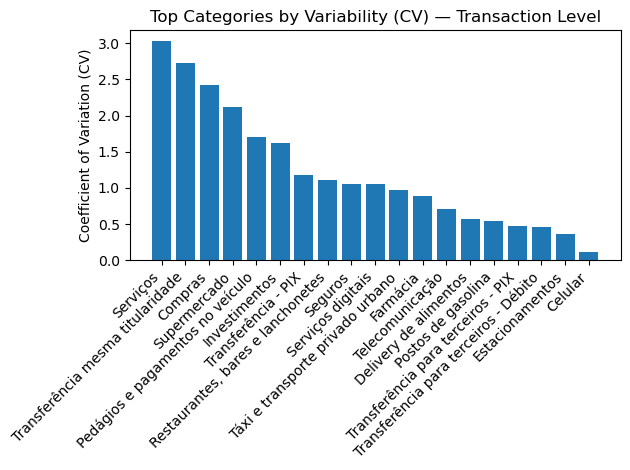

In [88]:
# Parameters
MIN_COUNT = 5   # Minimum number of transactions required to include a category in the analysis
TOP_N = 51      # Number of top categories (by coefficient of variation) to display

# Filter the dataset to include only transactions with positive effective outflows
# (i.e., actual spending after refunds or reversals have been applied)
tx_eff = df_tx[df_tx["effective_outflow"] > 0].copy()

# Aggregate basic statistics by category
# - count: number of valid spending transactions
# - mean: average transaction value
# - std: standard deviation of transaction values
agg = (
    tx_eff.groupby("category")["effective_outflow"]
          .agg(["count", "mean", "std"])
          .reset_index()
)

# Compute the coefficient of variation (CV = std / mean),
# which measures the relative variability of spending within each category.
agg["cv"] = agg["std"] / agg["mean"]

# Filter out categories with too few transactions or undefined mean values
# (avoids unstable CV values from small or zero-mean samples)
agg = agg[(agg["count"] >= MIN_COUNT) & (agg["mean"] > 0)]

# Sort by CV descending to identify the most volatile categories
top_cv = agg.sort_values("cv", ascending=False).head(TOP_N)

plt.figure()
plt.bar(top_cv["category"], top_cv["cv"])  # Bar height = CV per category
plt.title("Top Categories by Variability (CV) — Transaction Level")
plt.ylabel("Coefficient of Variation (CV)")
plt.xticks(rotation=45, ha="right")        # Rotate labels for readability
plt.tight_layout()

plt.savefig('cv_category_tx.png', dpi = 300, format = 'png')

plt.show()

### Monthly Net Cash Trend

This plot shows the evolution of the monthly Net Cash, calculated as the total sum of `amount` (inflows minus outflows) per month.

- Positive values indicate net inflows (more money coming in than going out).  
- Negative values indicate net outflows (spending exceeds inflows).  
- The horizontal line at zero serves as a reference baseline to distinguish months with positive or negative cash balance trends.

This visualization helps quickly identify seasonal patterns, months with unusually high spending, or improvements/drops in cash flow over time.


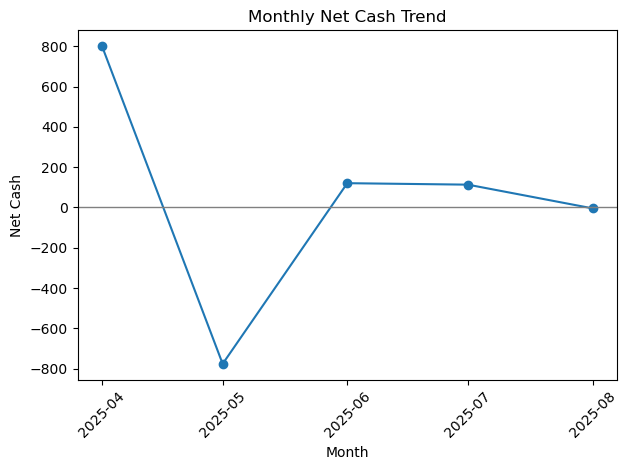

In [89]:
# Compute total monthly net cash = sum of inflows - outflows
# (since 'amount' = inflow - outflow at transaction level)
monthly_net = (
    df_tx.groupby('year_month')['amount']
    .sum()            # total net cash for each month
    .to_timestamp()   # convert PeriodIndex to Timestamp for plotting
    .sort_index()     # ensure chronological order
)

# Create a simple time-series line plot
plt.figure()
plt.plot(monthly_net.index, monthly_net.values, marker='o')

# Add a horizontal reference line at zero to distinguish positive/negative months
plt.axhline(0, linewidth=1, color='gray')

# Titles and axis labels
plt.title('Monthly Net Cash Trend')
plt.xlabel('Month')
plt.ylabel('Net Cash')

# Format x-axis labels as YYYY-MM and rotate for readability
plt.xticks(monthly_net.index, [d.strftime('%Y-%m') for d in monthly_net.index], rotation=45)

# Optimize layout and render
plt.tight_layout()
plt.show()


### Effective Spending by Category (Last Month)

This bar chart displays the effective outflow (net spending after refunds) for the top categories in the most recent month.  
It highlights where most of the expenses are concentrated.

- The bars are sorted by total effective outflow, showing the top N categories (default: 12).  
- The y-axis uses a logarithmic scale, allowing both large and small categories to be visualized together.  
- This view helps identify which spending categories dominate total expenses and how they compare across the main cost drivers.

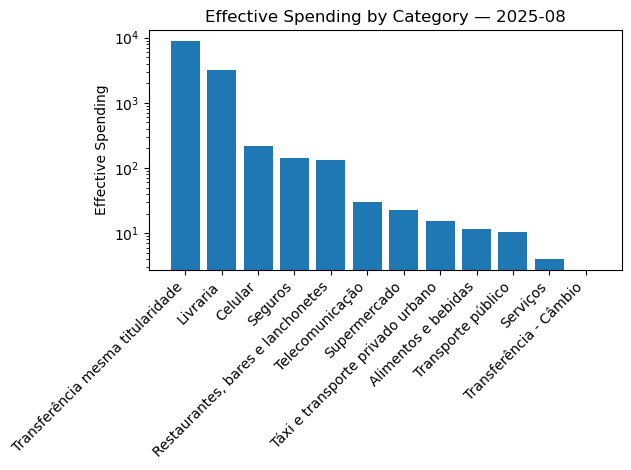

In [90]:
# --- Effective Spending by Category (Last Month) ------------------------------

N = 12  # number of top categories to show (adjust as needed)

# Identify the last available month in the data
last_month = df_tx["year_month"].max()
last_str = str(last_month)

# Select the subset of monthly data for that month and pick top N categories by effective outflow
cats_last = (
    monthly[monthly["month"] == last_str]
    .sort_values("effective_outflow", ascending=False)
    .head(N)
)

# Create a bar chart of effective spending per category
plt.figure()
plt.bar(cats_last["category"], cats_last["effective_outflow"])

# Add title and labels
plt.title(f"Effective Spending by Category — {last_str}")
# plt.xlabel("Category")  # optional label, often implicit in the x-ticks
plt.ylabel("Effective Spending")

# Rotate category labels for readability
plt.xticks(rotation=45, ha="right")

# Log scale helps visualize wide differences in category spending magnitude
plt.yscale("log")

# Improve layout and show plot
plt.tight_layout()
plt.show()


### Historical Causal Coefficient of Variation (CV) by Category

This bar chart ranks categories by their historical causal CV, which measures how variable their monthly effective outflows have been over time.

- The CV (Coefficient of Variation) is computed as the ratio between the standard deviation and the mean of past monthly totals (considering only previous months — *causal* approach).  
- Categories with high CV values show more inconsistent or irregular spending patterns.  
- The plot shows the top N categories with the highest historical variability for the latest month, helping identify unstable or unpredictable expense categories.  
- A higher CV implies greater volatility relative to average spending.


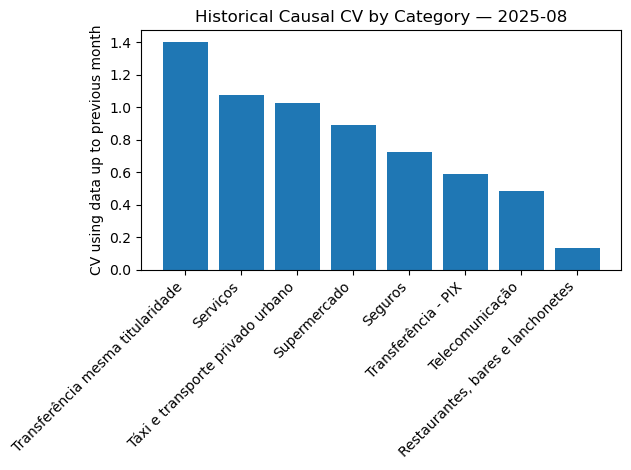

In [91]:
TOP_N = 15  # number of categories to display
last_ym = df_tx["year_month"].max()  # latest available year-month period

# Filter data for the last month, keeping only categories with enough historical data
cv_last = (
    month_cat[month_cat["year_month"] == last_ym]
    .dropna(subset=["cv_hist_causal"])  # remove categories without a valid historical CV
    .sort_values("cv_hist_causal", ascending=False)  # rank by CV descending
    .head(TOP_N)  # top N most variable categories
)

# Create a bar chart to visualize the variability
plt.figure()
plt.bar(cv_last["category"], cv_last["cv_hist_causal"])

# Titles and axis labels
plt.title(f"Historical Causal CV by Category — {str(last_ym)}")
plt.ylabel("CV using data up to previous month")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to prevent label overlap and display
plt.tight_layout()
plt.show()


### Heatmap of Effective Outflow by Month and Category

This heatmap visualizes how effective spending (after refunds) evolves over time across different categories.

- Each row represents a spending category.  
- Each column represents a month.  
- The color intensity encodes the log₁₀ of the effective outflow amount, so:
  - Darker colors indicate lower spending.
  - Lighter colors indicate higher spending.

Only the top categories (default: top 15) by total effective outflow are displayed, allowing focus on the most relevant expense drivers.

By reading across a row, you can see how spending for a specific category changes month to month.  
By reading down a column, you can compare which categories dominated spending in a given month.

The logarithmic color scale helps visualize both large and small categories on the same scale, avoiding domination by extreme values.


C:\Users\igorr\AppData\Local\Temp\ipykernel_16268\2892992607.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(mat.values), aspect="auto")  # default colormap (viridis)


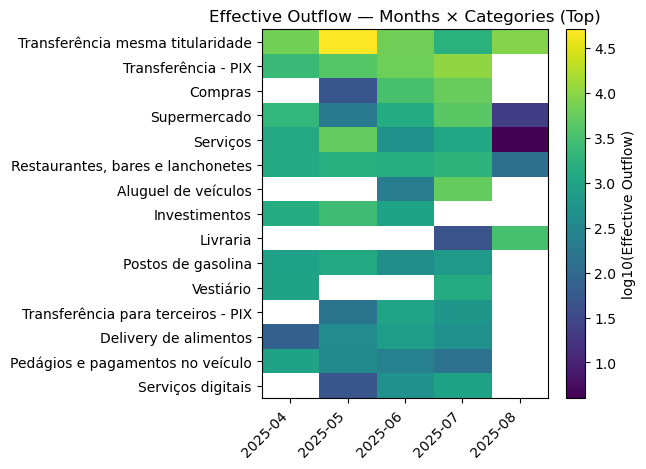

In [92]:
# --- Heatmap of Effective Outflow by Month × Category --------------------------

topK = 15  # number of top categories to include (by total effective outflow)

# Pivot table: rows = category, columns = month, values = sum of effective_outflow
pivot_eff = (
    monthly.pivot_table(
        index="category",
        columns="month",
        values="effective_outflow",
        aggfunc="sum"
    )
    .fillna(0.0)  # replace missing months/categories with zeros
)

# Select the top K categories by total effective outflow across all months
top_cats = pivot_eff.sum(axis=1).sort_values(ascending=False).head(topK).index
mat = pivot_eff.loc[top_cats]

# Plot heatmap: use log10 scale to compress large dynamic range of spending
plt.figure()
plt.imshow(np.log10(mat.values), aspect="auto")  # default colormap (viridis)
plt.colorbar(label="log10(Effective Outflow)")

# Titles and axis labels
plt.title("Effective Outflow — Months × Categories (Top)")
# plt.xlabel("Month")
# plt.ylabel("Category")

# Use formatted month labels on x-axis and category names on y-axis
plt.xticks(range(mat.shape[1]), mat.columns.tolist(), rotation=45, ha="right")
plt.yticks(range(mat.shape[0]), mat.index.tolist())

# Improve layout to avoid label overlap
plt.tight_layout()
plt.show()
